#### What does each filter look like when it is maximally activated?

Convulutional neural networks are complex structures that are quite difficult to understand. Even farther removed from the realms of knowledge is an intimate understanding of what is actually going on inside of these 'black-box' structures. Millions of datapoint creating thousands or hundreds of thousands of linear models, linked together and then backpropagated through does not the realm of human knowledge make. 

One way we can approach a (partial) understanding of what (may) be going on inside of these networks is to visualize the layers by finding images that correlate to maximal activation of specific filters. The images that result from these visualizations make us wonder, dream, and think. 

The following notebook seeks to implement code shared by Francois Chollet, author of Keras and Deep Learning expert at Google. 

Blog post: https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

Github: https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py

Twitter: https://twitter.com/fchollet

In [1]:
from __future__ import print_function

from scipy.misc import imsave
import numpy as np
import time
from keras import backend as K

Using TensorFlow backend.


In [2]:
from keras import applications

# build the VGG16 network
model = applications.VGG16(include_top=False,
                           weights='imagenet')

In [3]:
model.input

<tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>

In [16]:
%run __initremote__.py

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [86]:
from keras.models import load_model
model = load_model('datagen_115.h5')

In [59]:
weights = model.get_weights()

In [18]:
class_names_list = ['airplane',
                    'automobile',
                    'bird',
                    'cat',
                    'deer',
                    'dog',
                    'frog',
                    'horse',
                    'ship',
                    'truck']

In [ ]:
y_train = y_train.tolist()

for y in range(len(y_train)):
    y_train[y] = y_train[y][0]
    
y_train

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_unique_images(images, labels, class_names=class_names_list):
    unique_labels = []
    unique_indices = []
    
    fig = plt.figure(figsize=(6,3))
    
    n = 0
    for i in range(len(labels)):
        if labels[i] not in unique_labels:
            #image = images[i].reshape(3,32,32).transpose(1,2,0)
            image = images[i]
            plt.subplot(2,5,n+1)
            n += 1
            plt.imshow(image, interpolation="nearest")
            plt.title(class_names[labels[i]])
            unique_labels.append(labels[i])
            unique_indices.append(i)
    plt.show()
    
    return unique_indices

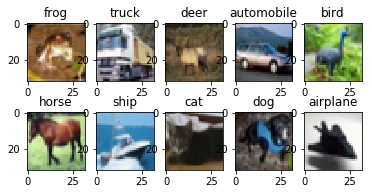

In [52]:
indices = show_unique_images(x_train, y_train)

From notebook 00-EDA, I wanted to pull in some images to get a starting point of reference. One thing to keep in mind, however, is that as I visualize these filters, 

In [4]:
img_width = 128
img_height = 128

In [5]:
model.layers

In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x7f84dd421668>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x7f8497e45320>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x7f8497e454e0>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x7f8497dfc908>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x7f8497e0ec50>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x7f8497e200b8>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x7f8497dc1630>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x7f8497dc1f28>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x7f8497de25f8>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x7f8497d86278>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x7f8497da7080>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x7f8497da7f98>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x7f8497d39518>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x7f8497d591d

In [7]:
input_img = model.input

In [8]:
input_img

<tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>

In [9]:
#layer_name = 'conv2d_29'
layer_name = 'block5_conv1'

filter_index = 0

layer_output = layer_dict[layer_name].output
#Utilizes backend function K.mean() to find the mean of a Tensor
loss = K.mean(layer_output[:, :, :, filter_index])
grads = K.gradients(loss, input_img)[0]


In [10]:
layer_output

<tf.Tensor 'block5_conv1/Relu:0' shape=(?, ?, ?, 512) dtype=float32>

In [11]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
iterate = K.function([input_img], [loss, grads])

In [15]:
def deprocess_image(x):
    '''Returns the image to a 0 to 255 range int'''
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [16]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [17]:
# we start from a gray image with some noise
input_img_data = np.random.random((1, 3, img_width, img_height)) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

ValueError: Cannot feed value of shape (1, 3, 128, 128) for Tensor 'input_1:0', which has shape '(?, ?, ?, 3)'

In [ ]:
img = input_img_data[0]
img = deprocess_image(img)
#imsave('%s_filter_%d.png' % (layer_name, filter_index), img)
plt.imshow(img, )